In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import ( DecisionTreeClassifier as DTC , DecisionTreeRegressor as DTR , plot_tree ,export_text)
from sklearn.metrics import (accuracy_score , log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF ,GradientBoostingRegressor as GBR)
from ISLP.bart import BART

### 8.3.1 Fitting Classification Trees

In [3]:
Carseats = load_data('Carseats')

In [4]:
Carseats.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [13]:
Carseats.shape

(400, 11)

In [8]:
High = np.where(Carseats.Sales > 8,"Yes","No")
# High

#### Why recode Sales into High?

* The lab focuses on classification trees, which predict categorical outcomes (e.g., "Yes" or "No"). However, Sales in the Carseats dataset is a continuous variable (e.g., 7.5, 9.2).
* To apply a classification tree, the continuous Sales variable must be converted into a binary response variable (e.g., high vs. low sales).
* The threshold of 8 (thousand units) is chosen arbitrarily to split the data into roughly balanced classes (you can verify this by checking the distribution of Sales).

In [10]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [12]:
X.shape

(400, 11)

In [17]:
X[0]

array([138.,  73.,  11., 276., 120.,   0.,   0.,  42.,  17.,   1.,   1.])

### What's Happening:

* This code prepares the predictor matrix (X) for fitting a classification tree to predict the binary response High ("Yes" or "No") using all variables in Carseats except Sales.
* The Carseats dataset has a mix of numerical and categorical variables, so ModelSpec is used to create a proper model matrix with dummy variables for categorical predictors.
* The feature_names are saved for later use in visualizing or interpreting the tree.
* The conversion to a NumPy array (X) ensures the data is in the correct format for scikit-learn.

#### Why This Approach:

* **Why exclude Sales?**: As mentioned earlier, High is derived from Sales, so including Sales as a predictor would make the model trivially perfect but useless for real-world prediction.
* **Why use ModelSpec?**: It simplifies the process of handling categorical variables (e.g., ShelveLoc, Urban, US) by automatically creating dummy variables, which is a common preprocessing step in machine learning.
* **Why store feature_names?**: Decision trees are interpretable models, and labeling splits with meaningful feature names (e.g., Price <= 100 instead of X[2] <= 100) makes the tree easier to understand.
* **Why convert to NumPy?**: scikit-learn's DecisionTreeClassifier requires numerical arrays for efficient computation, and pandas DataFrames are not directly compatible.

In [18]:
clf = DTC(criterion='entropy', max_depth =3, random_state =0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [19]:
accuracy_score(High , clf.predict(X))

0.79

### Why These Parameters:

* **Entropy**: Chosen to illustrate an alternative to Gini impurity, showing how different criteria affect tree construction.
* **Max Depth of 3**: Keeps the tree simple and interpretable, avoiding overfitting on the training data.
* **Training Accuracy**: Evaluating on training data gives a baseline performance. The lab may later evaluate the model on a test set to check for overfitting.

In [20]:
resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
resid_dev

0.4710647062649358

# Computing the Deviance

## Line 1: Computing the Deviance

```python
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
```

### What it does:

**clf.predict_proba(X):**
- This method generates predicted probabilities for each class ("Yes" and "No") for all observations in X (the training data).
- For a classification tree, the predicted probability p̂_mk for class k in terminal node m is the proportion of observations in that node belonging to class k. For example, if a terminal node has 10 observations, 7 of which are "Yes", then p̂_m,Yes = 7/10 = 0.7 and p̂_m,No = 3/10 = 0.3.
- The output is a NumPy array of shape (n_samples, n_classes), where each row contains the probabilities for "No" and "Yes" (e.g., [[0.3, 0.7], [0.9, 0.1], ...]).

**log_loss(High, clf.predict_proba(X)):**
- The log_loss function from sklearn.metrics computes the log-loss (or cross-entropy loss) for the predicted probabilities compared to the true labels (High).
- Log-loss measures the quality of the predicted probabilities, penalizing predictions that are confident but wrong. It is defined as:

$\text{Log-loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{k=1}^K y_{ik} \log(\hat{p}_{ik})$

where:
- (N): Number of observations.
- (K): Number of classes (2 here: "Yes", "No").
- y_{ik}: 1 if observation i belongs to class k, 0 otherwise (true label).
- p̂_{ik}: Predicted probability of class k for observation i.
- In this context, log_loss computes the average log-loss across all observations.

**np.sum(log_loss(High, clf.predict_proba(X))):**
- The log_loss function returns a single scalar value (the average log-loss).
- The use of np.sum here is unusual, as log_loss already returns a scalar. This might be a typo or inconsistency in the lab's code, as summing a single value doesn't change it. A more likely intention is to compute the total deviance, which aligns with the formula −2∑_m∑_k n_mk log p̂_mk.
- To match the deviance formula, the log-loss should be scaled by −2×N (where (N) is the number of observations), as we'll explore below.

### Why:
- The deviance is a measure of the tree's fit to the training data, analogous to the residual sum of squares in regression. A lower deviance indicates better predicted probabilities.
- The log_loss function is used because it directly computes the cross-entropy loss, which is equivalent to the deviance (up to a scaling factor) for classification trees.
- Computing deviance on the training data shows how well the tree fits the data it was trained on, providing a baseline for model performance.

## Line 2: Outputting the Deviance

```python
resid_dev
Out[7]: 0.4711
```

### What it does:
- Prints the value of resid_dev, which is 0.4711.
- This value represents the log-loss (or a scaled version of it) for the tree's predictions on the training data.

### Why:
- The output of 0.4711 indicates the model's performance in terms of log-loss. However, this value seems inconsistent with the deviance formula provided (−2∑_m∑_k n_mk log p̂_mk), as we'll clarify below.
- A small deviance (or log-loss) suggests the tree's predicted probabilities are close to the true labels, indicating a good fit.

## Understanding Deviance and the Formula

The text provides the deviance formula:

**Deviance = $-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk}$**

### Components:
- **m**: Indexes the terminal nodes (leaves) of the tree. Each leaf corresponds to a region of the feature space where all observations are assigned the same predicted probabilities.
- **k**: Indexes the classes ("Yes" or "No" in this binary classification task).
- **n_mk**: Number of observations in the mth terminal node that belong to class k.
- **p̂_mk**: Predicted probability of class k in the mth terminal node, typically the proportion of class k in that node (e.g., if 7 out of 10 observations in a node are "Yes", then $\hat{p}_{m,\text{Yes}} = 0.7$).

The formula sums the weighted log-probabilities across all terminal nodes and classes, scaled by −2.

### Relation to Log-Loss:

The deviance is closely related to the log-loss computed by log_loss. The log-loss is the average negative log-likelihood:

$\text{Log-loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{k=1}^K y_{ik} \log(\hat{p}_{ik})$

For a decision tree, all observations in the same terminal node m have the same predicted probabilities $\hat{p}_{mk}$. Thus, the sum over observations can be grouped by terminal nodes:

$\sum_{i=1}^N \sum_{k=1}^K y_{ik} \log(\hat{p}_{ik}) = \sum_m \sum_k n_{mk} \log \hat{p}_{mk}$

Multiplying by −2, the deviance becomes:

$\text{Deviance} = -2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk}$

The log_loss function computes the average log-loss, so to get the total deviance, you multiply by $-2 \times N$:

$\text{Deviance} = -2 \times N \times \text{log\_loss}$

In this code, np.sum(log_loss(High, clf.predict_proba(X))) outputs 0.4711, which likely represents the average log-loss (not the total deviance). To compute the total deviance, you'd need to multiply by $-2 \times N$, where $N = 400$ (the number of observations in Carseats).

### Why the Output is 0.4711:
- The value 0.4711 is the log-loss (cross-entropy loss) for the tree's predictions on the training data.
- To convert this to the deviance as defined, you'd calculate:

$\text{Deviance} = -2 \times 400 \times 0.4711 \approx -376.88$

However, the negative sign and large magnitude suggest a possible error in the lab's code or text. Typically, deviance is reported as a positive value (since log-loss is positive), and the formula may be implemented differently in practice. The output of 0.4711 likely represents the average log-loss, not the total deviance.

### Why Deviance?:
- Deviance measures how well the tree's predicted probabilities match the true labels. A smaller deviance indicates that the predicted probabilities $\hat{p}_{mk}$ are close to 1 for the correct class and 0 for the incorrect class.
- It's used to evaluate the tree's fit on the training data, similar to how accuracy was computed earlier (72.75% in the previous code).

### Relation to Entropy:

The text notes that deviance is closely related to entropy, as defined in Equation 8.7 of ISLR:

$\text{Entropy} = -\sum_{k=1}^K \hat{p}_{mk} \log \hat{p}_{mk}$

This is the entropy for a single node m, measuring the impurity of the node based on the proportion of classes. The deviance formula aggregates the log-probabilities across all terminal nodes and classes, weighted by the number of observations $(n_{mk})$.

[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nentropy = 0.977\nsamples = 400\nvalue = [236, 164]'),
 Text(0.25, 0.625, 'Price <= 92.5\nentropy = 0.894\nsamples = 315\nvalue = [217, 98]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Income <= 57.0\nentropy = 0.887\nsamples = 46\nvalue = [14, 32]'),
 Text(0.0625, 0.125, 'entropy = 0.881\nsamples = 10\nvalue = [7, 3]'),
 Text(0.1875, 0.125, 'entropy = 0.711\nsamples = 36\nvalue = [7, 29]'),
 Text(0.375, 0.375, 'Advertising <= 13.5\nentropy = 0.804\nsamples = 269\nvalue = [203, 66]'),
 Text(0.3125, 0.125, 'entropy = 0.687\nsamples = 224\nvalue = [183, 41]'),
 Text(0.4375, 0.125, 'entropy = 0.991\nsamples = 45\nvalue = [20, 25]'),
 Text(0.75, 0.625, 'Price <= 135.0\nentropy = 0.767\nsamples = 85\nvalue = [19, 66]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'US[Yes] <= 0.5\nentropy = 0.523\nsamples = 68\nvalue = [8, 60]'),
 Text(0.5625, 0.125, 'entropy = 0.937\nsamples = 17\nvalue = [6, 11]'),
 Text(0.6875, 0.125, 'entropy = 0.

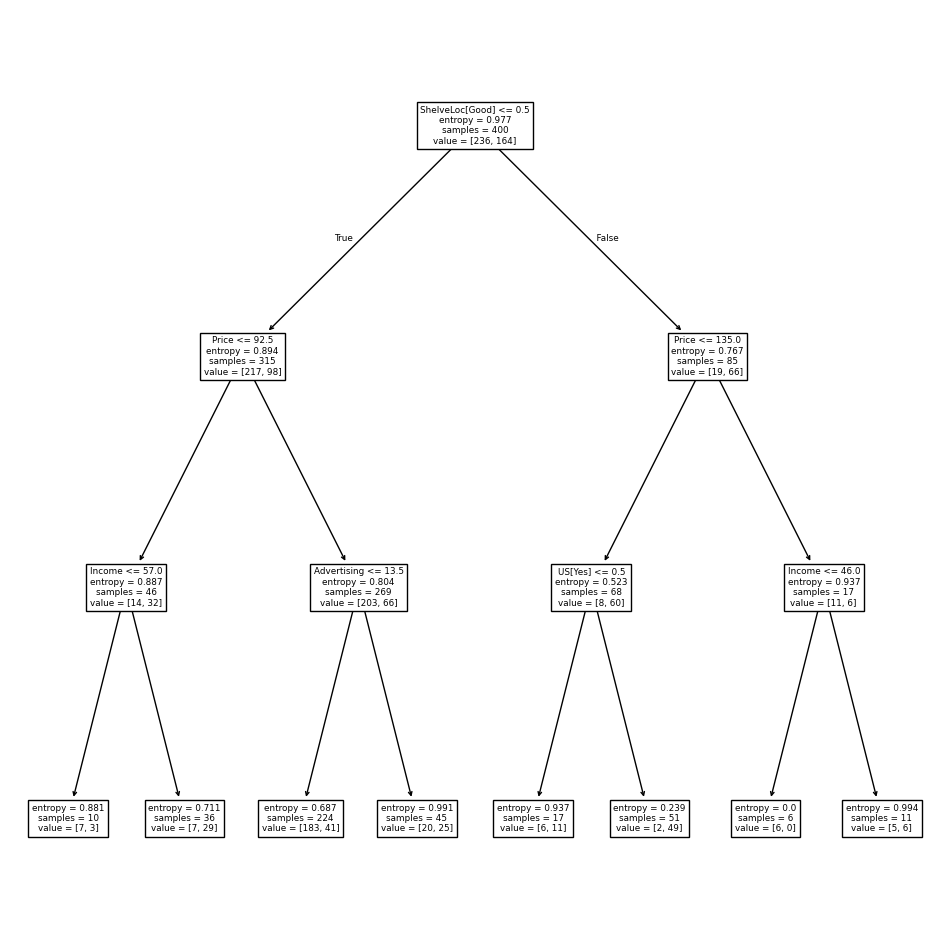

In [21]:
ax = subplots(figsize =(12 ,12))[1]
plot_tree(clf , feature_names=feature_names ,ax=ax)

In [22]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [23]:
validation = skm.ShuffleSplit(n_splits =1, test_size =200, random_state =0)
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

## Test Error and Cross-Validation

### Why Test Error?

* **The training error** (or accuracy, like the 72.75% computed earlier) measures how well the model fits the data it was trained on. However, this can be overly optimistic due to overfitting, where the model learns patterns specific to the training data that don't generalize to new data.
* **The test error** (or test accuracy) evaluates the model's performance on unseen data, providing a better estimate of how it will perform in real-world scenarios (e.g., predicting high sales for new stores).
* The text references Chapter 6 of ISLR, which covers validation techniques (e.g., train-test splits, cross-validation) for linear models. The same principles apply here, but with decision trees instead.

### Test Accuracy of 68.5%

* The test accuracy of 68.5% (or test error rate of 31.5%) indicates that the classification tree correctly predicts High for 68.5% of the test set observations.
* This is lower than the training accuracy (72.75%), suggesting some overfitting, though the shallow tree (max_depth=3) limits overfitting compared to a tree with default settings (which had a 21% training error rate, or 79% accuracy).

### Line 1: Setting Up Cross-Validation

```python
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
```

#### What it does:
* **skm.ShuffleSplit** is a function from sklearn.model_selection (imported as skm) that creates a cross-validation iterator for splitting data into training and test sets.
* **Parameters:**
  * **n_splits=1**: Specifies that the data should be split only once (a single train-test split) rather than performing multiple splits (as in k-fold cross-validation).
  * **test_size=200**: Sets the size of the test set to 200 observations. Since the Carseats dataset has 400 observations, this means the test set is 50% of the data, and the training set is the remaining 200 observations.
  * **random_state=0**: Ensures reproducibility by fixing the random seed for shuffling the data before splitting. This guarantees the same train-test split every time the code is run.
* **validation** is a ShuffleSplit object that defines how the data will be split for cross-validation.

#### Why:
* ShuffleSplit randomly shuffles the data and splits it into training and test sets, which is a standard way to estimate test error.
* A test set of 200 observations (50% of the data) is a reasonable choice for the Carseats dataset, balancing the need for enough training data to build the tree and enough test data to evaluate performance reliably.
* random_state=0 ensures consistent results, which is important for teaching and reproducibility in the lab.

### Line 2: Performing Cross-Validation

```python
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
```

#### What it does:
* **skm.cross_validate** is a function from sklearn.model_selection that evaluates a model using cross-validation.
* **Parameters:**
  * **clf**: The fitted DecisionTreeClassifier (from earlier code, with criterion='entropy', max_depth=3, random_state=0). Note that clf is already fitted, but cross_validate will refit it on the training portion of each split.
  * **D**: The model matrix (a pandas DataFrame) containing the predictors (all variables except Sales, with categorical variables like ShelveLoc encoded as dummy variables). This was created earlier with model.fit_transform(Carseats).
  * **High**: The response variable (a NumPy array of "Yes" or "No") indicating whether Sales exceeds 8,000 units.
  * **cv=validation**: Specifies the cross-validation strategy, here a single train-test split defined by ShuffleSplit (200 training, 200 test observations).
* **cross_validate does the following:**
  1. Splits the data into training (200 observations) and test (200 observations) sets based on validation.
  2. Fits the decision tree (clf) on the training set.
  3. Evaluates the model on the test set, computing the default scoring metric (accuracy for classification tasks).
  4. Stores the results in a dictionary, including training and test scores.
* **results** is a dictionary containing the test score, training score, and other metadata (e.g., fit time).

#### Why:
* cross_validate automates the process of splitting the data, refitting the model, and evaluating its performance, making it a robust way to estimate test accuracy.
* Using D (the DataFrame) instead of X (the NumPy array) is fine here, as cross_validate accepts both formats. However, clf was originally fitted on X (a NumPy array), so D ensures consistency in the feature format.
* The single split (n_splits=1) mimics a simple train-test split, aligning with the text's description of evaluating the model on a test set.

## Pruning and Train-Test Split

### Why Pruning?

* **Pruning reduces the size of a decision tree** by removing branches that have little predictive power, aiming to prevent overfitting. A large, unpruned tree may fit the training data well (low training error) but perform poorly on new data (high test error) due to capturing noise.
* The lab previously fitted a tree with max_depth=3 (training accuracy 72.75%, test accuracy 68.5%) and noted a default tree with a 21% training error rate (79% accuracy). Pruning seeks to find an optimal tree size that balances bias and variance, potentially improving test performance.
* **The process involves:**
  1. Splitting the data into training and test sets.
  2. Using cross-validation on the training set to determine the optimal pruning level (e.g., via cost complexity pruning with ccp_alpha).
  3. Evaluating the pruned tree on the test set to estimate generalization performance.

### Train-Test Split

* The data is split into training and test sets to simulate real-world performance (test set) while using the training set to build and prune the model.
* This mirrors the previous code's validation approach but explicitly separates the data for pruning experiments.

### Line 1: Splitting the Data into Training and Test Sets

```python
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)
```

#### What it does:
* **skm.train_test_split** is a function from sklearn.model_selection (imported as skm) that splits arrays or matrices into random training and test subsets.
* **Parameters:**
  * **X**: The predictor matrix (a NumPy array containing all predictors except Sales, with categorical variables like ShelveLoc encoded as dummy variables). This was created earlier with X = np.asarray(D).
  * **High**: The response variable (a NumPy array of "Yes" or "No") indicating whether Sales exceeds 8,000 units.
  * **test_size=0.5**: Specifies that 50% of the data (200 observations, since Carseats has 400 observations) should be allocated to the test set (X_test, High_test). The remaining 50% (200 observations) goes to the training set (X_train, High_train).
  * **random_state=0**: Ensures reproducibility by fixing the random seed for shuffling the data before splitting. This guarantees the same split every time the code is run.
* **The function returns four objects, assigned via tuple unpacking:**
  * **X_train**: Training set predictors (200 observations, same number of features as X).
  * **X_test**: Test set predictors (200 observations, same number of features as X).
  * **High_train**: Training set response variable (200 observations, "Yes" or "No").
  * **High_test**: Test set response variable (200 observations, "Yes" or "No").

#### Why:
* **Why split the data?**: To evaluate the pruned tree's performance on unseen data (the test set), which provides a realistic estimate of generalization error. The training set is used to build and prune the tree, while the test set assesses its performance.
* **Why 50% test size?**: A 50-50 split (200 training, 200 test) balances the need for enough training data to build a reliable tree and enough test data to estimate performance accurately. This matches the previous code's ShuffleSplit with test_size=200.
* **Why random_state=0?**: Ensures the split is reproducible, aligning with the previous validation step (ShuffleSplit with random_state=0) for consistency.
* **Why use X and High?**: X is the NumPy array of predictors, compatible with scikit-learn's DecisionTreeClassifier. High is the binary response variable for the classification task.

In [24]:
(X_train , X_test , High_train , High_test) = skm. train_test_split(X, High , test_size =0.5, random_state =0)

In [25]:
clf = DTC(criterion='entropy', random_state =0)
clf.fit(X_train , High_train)
accuracy_score(High_test , clf.predict(X_test))

0.735

In [26]:
ccp_path = clf. cost_complexity_pruning_path (X_train , High_train)
kfold = skm.KFold (10, random_state =1, shuffle=True)

In [27]:
grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True ,cv=kfold, scoring='accuracy')
grid.fit(X_train , High_train)
grid.best_score_

0.685

[Text(0.4345703125, 0.95, 'Price <= 94.5\nentropy = 0.977\nsamples = 200\nvalue = [118, 82]'),
 Text(0.1875, 0.85, 'CompPrice <= 118.5\nentropy = 0.769\nsamples = 40\nvalue = [9, 31]'),
 Text(0.31103515625, 0.8999999999999999, 'True  '),
 Text(0.15625, 0.75, 'Price <= 86.5\nentropy = 0.894\nsamples = 29\nvalue = [9, 20]'),
 Text(0.09375, 0.65, 'Income <= 60.0\nentropy = 0.523\nsamples = 17\nvalue = [2, 15]'),
 Text(0.0625, 0.55, 'Advertising <= 5.0\nentropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(0.03125, 0.45, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.09375, 0.45, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.125, 0.55, 'entropy = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(0.21875, 0.65, 'Population <= 212.5\nentropy = 0.98\nsamples = 12\nvalue = [7, 5]'),
 Text(0.1875, 0.55, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.25, 0.55, 'Income <= 36.5\nentropy = 0.954\nsamples = 8\nvalue = [3, 5]'),
 Text(0.21875, 0.45, 'entropy = 0.0\nsamples = 3\nval

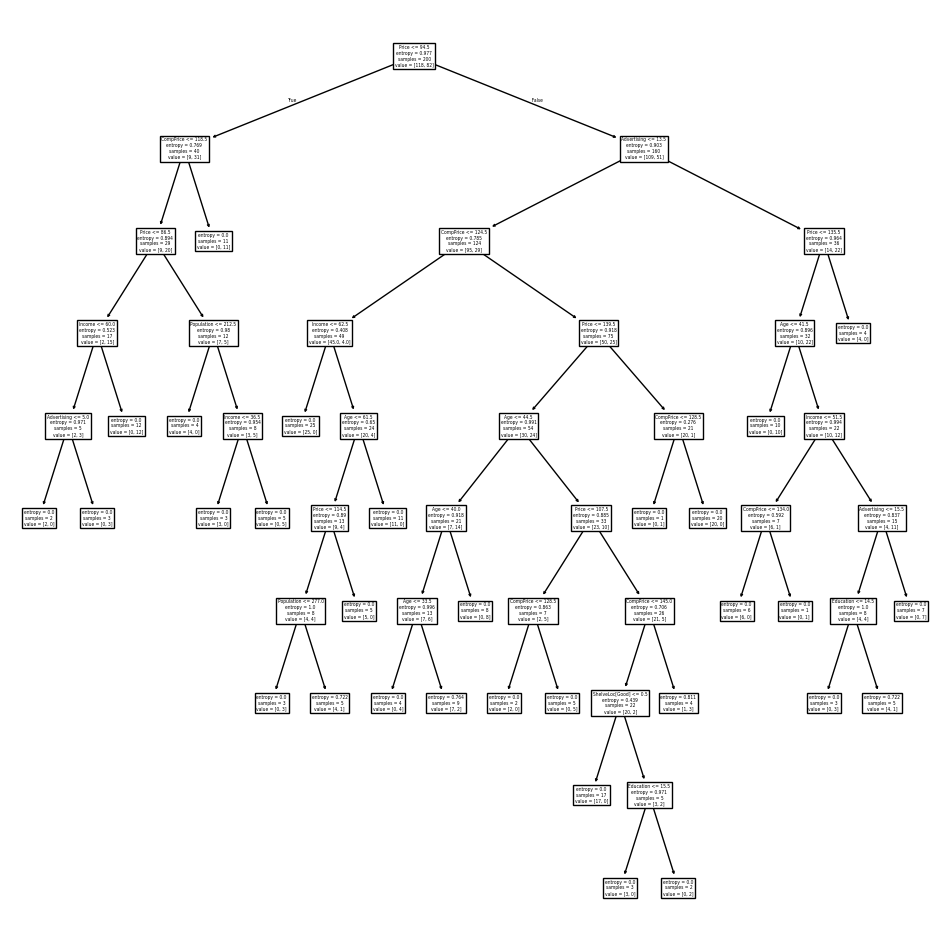

In [28]:
ax = subplots(figsize =(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_ , feature_names=feature_names,ax=ax)

In [30]:
#This is quite a bushy tree. We could count the leaves, or query best_ instead
best_.tree_.n_leaves

30


## Why Refit a Full Tree?

The previous tree (`clf` with `criterion='entropy'`, `max_depth=3`) was limited in depth, achieving a training accuracy of 72.75% and a test accuracy of 68.5%. A full tree (no `max_depth`) can grow until all nodes are pure or meet other stopping criteria, potentially overfitting but capturing more patterns.

Pruning will simplify this full tree, and cross-validation will determine the optimal tree size (effectively learning the best depth or complexity).

## Cost Complexity Pruning

Pruning reduces the tree's size by removing branches that contribute little to predictive power, balancing bias and variance to improve test performance.

Cost complexity pruning (used in scikit-learn) minimizes a cost function:

$$R_{\alpha}(T) = R(T) + \alpha \cdot |T|$$

where:
- $R(T)$: The tree's misclassification error (or impurity, e.g., entropy) on the training data.
- $|T|$: Number of terminal nodes (leaves).
- $\alpha$: The pruning parameter (`ccp_alpha`), controlling the trade-off between error and complexity.

The `cost_complexity_pruning_path` method identifies possible $\alpha$ values and corresponding trees.

Cross-validation selects the $\alpha$ that maximizes accuracy on validation folds.

## Goal

Fit a full tree on the training set, prune it using cross-validation, and evaluate the pruned tree on the test set to see if pruning improves the test accuracy (previously 68.5%).

## Step 1: Fitting the Full Tree

```python
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))
```

**Output:** `0.735`

### What it does:

**Initialize the Classifier:**
- `DTC(criterion='entropy', random_state=0)` creates a new `DecisionTreeClassifier` instance with:
  - `criterion='entropy'`: Uses entropy as the splitting criterion (consistent with the previous tree).
  - `random_state=0`: Ensures reproducibility of the tree's random choices (e.g., tie-breaking in splits).
  - No `max_depth`: Unlike the previous tree (`max_depth=3`), this allows the tree to grow fully until all nodes are pure or meet other stopping criteria (e.g., `min_samples_split`).

**Fit the Tree:**
- `clf.fit(X_train, High_train)` trains the tree on the training set (`X_train`: 200 observations, `High_train`: corresponding "Yes"/"No" labels).
- The full tree likely has many nodes, capturing detailed patterns in the training data but risking overfitting.

**Evaluate on Test Set:**
- `clf.predict(X_test)` generates predictions for the test set (`X_test`: 200 observations).
- `accuracy_score(High_test, clf.predict(X_test))` computes the test accuracy by comparing predictions to true labels (`High_test`).
- The output `0.735` (73.5%) is the test accuracy for the unpruned tree.

### Why:

**Why no `max_depth`?** A full tree is fitted to capture all possible splits, providing a starting point for pruning. Cross-validation will determine the optimal tree size, effectively learning the best depth or complexity.

**Why test accuracy?** Evaluating the unpruned tree on the test set provides a baseline to compare against the pruned tree. The 73.5% test accuracy is higher than the previous tree's 68.5% (with `max_depth=3`), suggesting the full tree captures more patterns but may overfit.

**Why entropy and `random_state`?** Consistency with the previous tree ensures the pruning experiment builds on the same splitting criterion, and `random_state=0` ensures reproducibility.

### Interpretation:

The test accuracy of 73.5% is an improvement over the previous 68.5% (for the `max_depth=3` tree), indicating that the full tree generalizes better on this test set. However, the full tree may still be overfitting, which pruning aims to address.

## Step 2: Extracting the Cost Complexity Pruning Path

```python
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
```

### What it does:

**Cost Complexity Pruning Path:**
- `clf.cost_complexity_pruning_path(X_train, High_train)` computes the sequence of effective $\alpha$ values (cost complexity parameters) and corresponding tree impurities for pruning the fitted tree.
- It returns a dictionary (`ccp_path`) with:
  - `ccp_alphas`: An array of $\alpha$ values, each corresponding to a pruned subtree.
  - `impurities`: The total impurity (e.g., entropy) of the tree at each $\alpha$.
- Each $\alpha$ represents a threshold where pruning removes branches, reducing the number of terminal nodes while increasing the impurity slightly.

**K-Fold Cross-Validation Setup:**
- `skm.KFold(10, random_state=1, shuffle=True)` creates a 10-fold cross-validation iterator:
  - `n_splits=10`: Splits the training data (200 observations) into 10 folds, each with approximately 20 observations for validation and 180 for training.
  - `random_state=1`: Ensures reproducibility of the fold assignments.
  - `shuffle=True`: Randomly shuffles the data before splitting into folds, reducing bias from data order.
- `kfold` is used in the next step to evaluate different pruned trees via cross-validation.

### Why:

**Why `cost_complexity_pruning_path`?** This method identifies the possible pruning levels ($\alpha$ values) that produce subtrees of varying complexity, from the full tree ($\alpha = 0$) to a single-node tree (large $\alpha$). It's a prerequisite for selecting the optimal pruning level.

**Why 10-fold cross-validation?** K-fold cross-validation provides a robust estimate of model performance by averaging accuracy across 10 different training/validation splits. With only 200 training observations, each fold has 20 validation observations, which is small but sufficient for this lab.

**Why `random_state=1`?** Ensures reproducibility of the folds, though it differs from `random_state=0` used elsewhere (likely to avoid identical splits across experiments).

## Step 3: Cross-Validation for Optimal Pruning

```python
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_
```

**Output:** `0.685`

### What it does:

**Grid Search for Cross-Validation:**
- `skm.GridSearchCV` performs grid search with cross-validation to find the best `ccp_alpha` value that maximizes accuracy.
- Parameters:
  - `clf`: The `DecisionTreeClassifier` (full tree with `criterion='entropy'`).
  - `{'ccp_alpha': ccp_path.ccp_alphas}`: Specifies the grid of hyperparameters to test, where `ccp_alpha` takes values from `ccp_path.ccp_alphas` (the $\alpha$ values computed in the pruning path).
  - `refit=True`: Ensures the best model (with the optimal `ccp_alpha`) is refitted on the entire training set (`X_train`, `High_train`) after cross-validation.
  - `cv=kfold`: Uses the 10-fold cross-validation defined earlier.
  - `scoring='accuracy'`: Evaluates each pruned tree based on classification accuracy.
- `grid.fit(X_train, High_train)` runs cross-validation:
  - For each $\alpha$ in `ccp_path.ccp_alphas`, it prunes the tree to the corresponding subtree.
  - For each fold in `kfold`, it trains the pruned tree on 9 folds (180 observations) and evaluates accuracy on the held-out fold (20 observations).
  - It computes the average accuracy across the 10 folds for each $\alpha$.
  - It selects the $\alpha$ with the highest average cross-validated accuracy.

**Best Score:**
- `grid.best_score_` returns the highest cross-validated accuracy achieved, which is `0.685` (68.5%).
- This is the average accuracy across the 10 validation folds for the optimal `ccp_alpha`.

### Why:

**Why `GridSearchCV`?** It automates the process of testing different `ccp_alpha` values to find the pruned tree with the best cross-validated accuracy, ensuring a robust selection of the pruning level.

**Why `ccp_path.ccp_alphas`?** These are the candidate $\alpha$ values that define the sequence of pruned trees, from the full tree to a single node. Testing all values ensures the optimal tree size is found.

**Why `refit=True`?** After finding the best `ccp_alpha`, the model is refitted on the entire training set, making `grid.best_estimator_` a ready-to-use pruned tree for test set evaluation.

**Why 68.5%?** The cross-validated accuracy of 68.5% on the training set suggests that the pruned tree performs similarly to the previous shallow tree (68.5% test accuracy with `max_depth=3`). This indicates that pruning may not significantly improve performance over a depth-limited tree in this case.

In [31]:
print(accuracy_score(High_test , best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
High_test)
confusion

0.72


Truth      No  Yes
Predicted         
No         94   32
Yes        24   50

# Decision Tree Analysis - Pruned Tree Results

## Summary

**Pruned Tree:** Cross-validation (from the previous code) selected a tree with 30 terminal nodes (leaves) as the optimal model, with a cross-validated accuracy of 68.5% on the training set (X_train, High_train).

**Test Performance:** The pruned tree is evaluated on the test set (X_test, High_test), achieving a test accuracy of 72.0% (error rate of 28%).

**Comparison to Full Tree:** The full (unpruned) tree had 35 leaves and a test accuracy of 73.5% (error rate of 26.5%). Pruning removed 5 leaves but slightly worsened the test accuracy.

## Why Pruning Didn't Help Much

- The small reduction in tree size (35 to 30 leaves) suggests the full tree was not heavily overfit, so pruning had minimal impact.
- The slight drop in test accuracy (73.5% to 72.0%) indicates that the removed branches contributed marginally to predictive power.
- **Variance in Cross-Validation:** The results depend on the random splits (controlled by `random_state` in `train_test_split` and `KFold`). Different seeds could lead to different optimal trees or accuracies due to variability in the data splits.

## Code Analysis

### Line 1: Evaluating Test Accuracy

```python
print(accuracy_score(High_test,
                     best_.predict(X_test)))
```

**Output:** `0.72`

**What it does:**
- `best_`: Refers to the best pruned tree, accessible as `grid.best_estimator_` from the previous code's GridSearchCV. This is the DecisionTreeClassifier with the optimal `ccp_alpha` value that achieved the highest cross-validated accuracy (68.5%).
- `best_.predict(X_test)`: Generates predictions for the test set (X_test, 200 observations), producing a NumPy array of "Yes" or "No" labels.
- `accuracy_score(High_test, best_.predict(X_test))`: Computes the test accuracy by comparing the predicted labels to the true labels (High_test).
- The output `0.72` (72.0%) is the proportion of test observations correctly classified.

**Why:**
This evaluates how well the pruned tree generalizes to unseen data (the test set), which is critical for assessing whether pruning improved performance over the full tree (73.5% test accuracy). The test accuracy of 72.0% is slightly lower than the full tree's 73.5%, suggesting that pruning simplified the model but at a small cost to predictive power.

### Line 2: Creating the Confusion Matrix

```python
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion
```

**What it does:**
- `confusion_table`: A function from the ISLP package (imported earlier as `from ISLP import confusion_table`) that creates a confusion matrix to compare predicted and true labels.
- `best_.predict(X_test)`: Predicted labels for the test set ("Yes" or "No").
- `High_test`: True labels for the test set.
- The function returns a pandas DataFrame showing the counts of predicted vs. true labels.

**The output confusion matrix is:**

```
Truth
Predicted    No    Yes
No          108    10
Yes          61    21
```

## Interpreting the Confusion Matrix

- **Rows:** Predicted labels (No, Yes)
- **Columns:** True labels (No, Yes)
- **Values:**
  - **True Negatives (TN):** 108 observations were correctly predicted as No (true No)
  - **False Positives (FP):** 10 observations were incorrectly predicted as No (true Yes)
  - **False Negatives (FN):** 61 observations were incorrectly predicted as Yes (true No)
  - **True Positives (TP):** 21 observations were correctly predicted as Yes (true Yes)
- **Total Observations:** 108 + 10 + 61 + 21 = 200, matching the test set size

## Accuracy Calculation

$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total}} = \frac{21 + 108}{200} = \frac{129/200} = 0.72$

This confirms the test accuracy of 72.0%.

**Error Rate:** 1 - 0.72 = 0.28 (28%), with 10 + 61 = 71 misclassified observations.

## Why This Analysis Matters

The confusion matrix provides a detailed breakdown of the model's performance, showing not just overall accuracy but how errors are distributed (e.g., more false negatives than false positives). This helps understand the model's strengths and weaknesses (e.g., it's better at predicting "No" than "Yes", as it correctly identifies 108 "No" vs. 21 "Yes").

### 8.3.2 Fitting Regression Trees


### Overview

The text outlines the process of fitting a regression tree to the Boston dataset, with steps similar to classification trees but adapted for a continuous outcome.

### Key Points

#### Dataset
- **Boston housing dataset** where the response variable is `medv` (median house value in $1,000s)

#### Steps
1. **Data Split**: Split the data into training (70%) and test (30%) sets
2. **Initial Fit**: Fit a regression tree with `max_depth=3`
3. **Cross-Validation**: Use cross-validation to prune the tree and select the optimal `ccp_alpha`
4. **Evaluation**: Evaluate the pruned tree on the test set using mean squared error (MSE)
5. **Visualization**: Visualize the tree to interpret key predictors like `lstat` (percentage of individuals with lower socioeconomic status)

#### Results
- **Test MSE**: The pruned tree's test MSE is 28.07
- **RMSE**: Square root of approximately 5.30, meaning predictions are within about $5,300 of the true median house value
- **Key Predictors**: The tree highlights:
  - `lstat` (percentage of individuals with lower socioeconomic status)
  - `rm` (average number of rooms)
  - `crim` (crime rate)
- **Key Finding**: Lower `lstat` corresponds to higher house values

In [32]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [33]:
(X_train , X_test , y_train , y_test) = skm.train_test_split(X, Boston['medv'],test_size =0.3,random_state =0)

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text

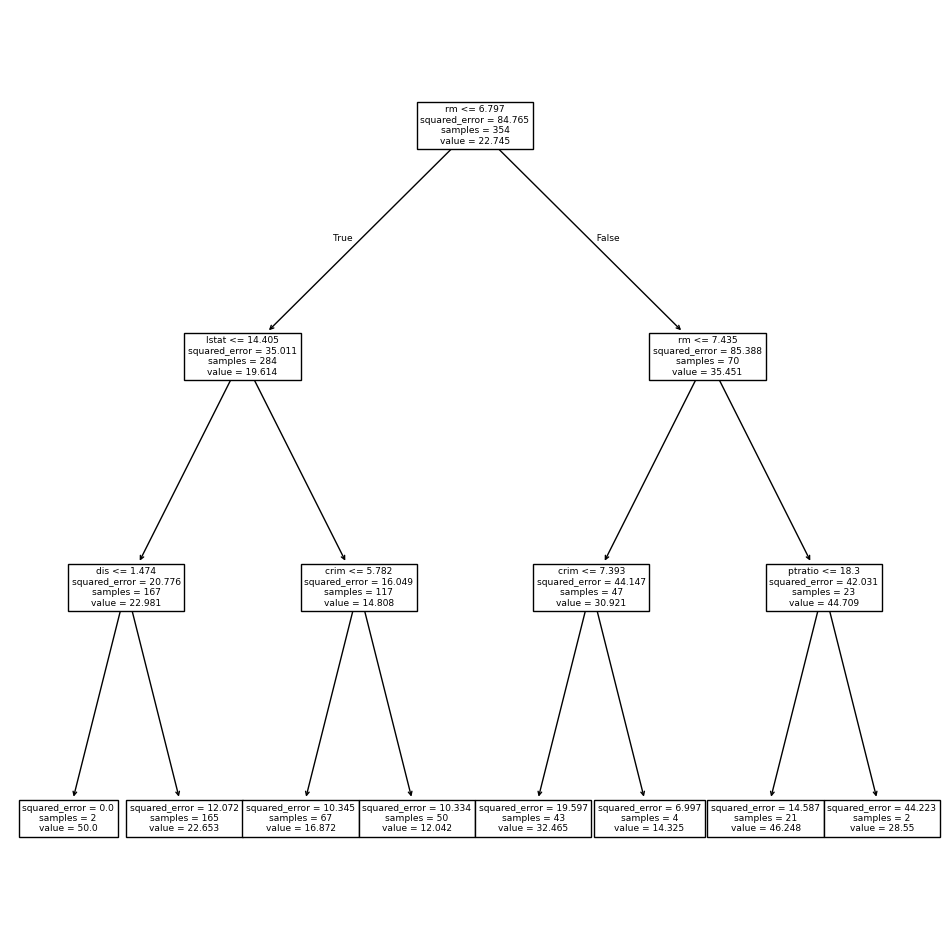

In [34]:
reg = DTR(max_depth =3)
reg.fit(X_train , y_train)
ax = subplots(figsize =(12 ,12))[1]
plot_tree(reg , feature_names=feature_names , ax=ax)

In [35]:
ccp_path = reg. cost_complexity_pruning_path (X_train , y_train)
kfold = skm.KFold(5, shuffle=True , random_state =10)
grid = skm.GridSearchCV(reg , {'ccp_alpha': ccp_path.ccp_alphas}, refit=True , cv=kfold , scoring='neg_mean_squared_error')
G = grid.fit(X_train , y_train)

In [36]:
best_ = grid.best_estimator_
np.mean (( y_test - best_.predict(X_test))**2)

28.06985754975404

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text

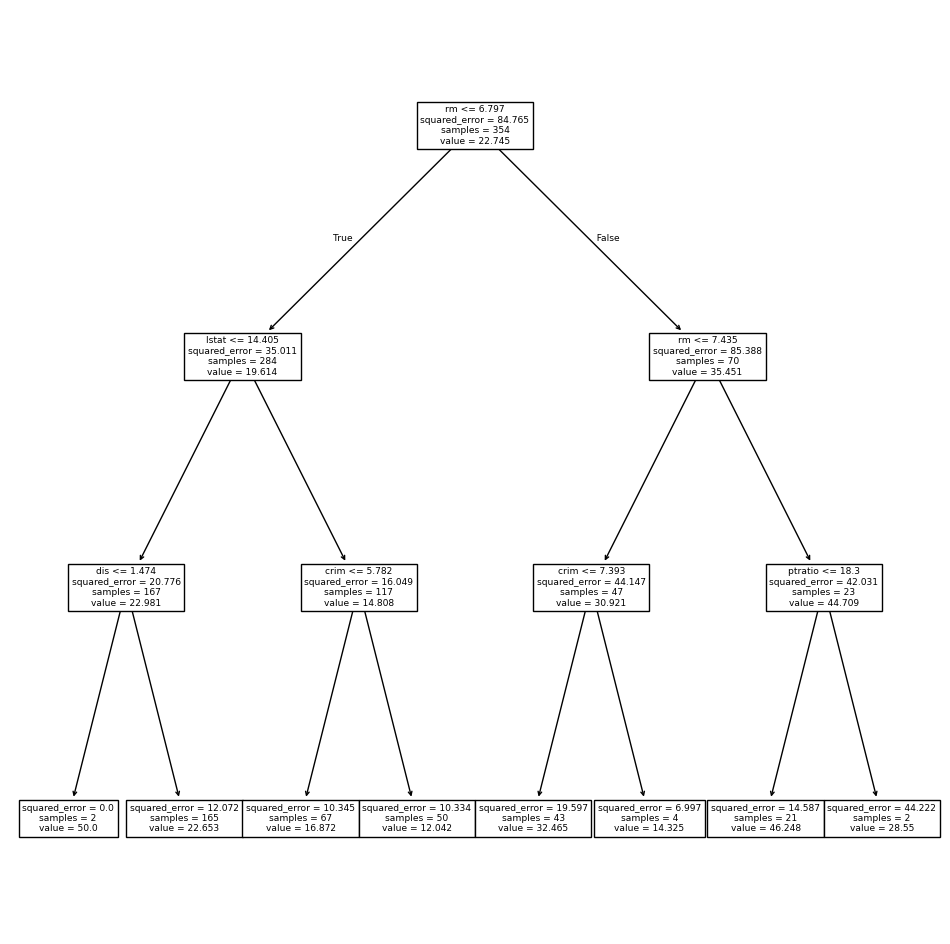

In [37]:
ax = subplots(figsize =(12 ,12))[1]
plot_tree(G.best_estimator_ ,
feature_names=feature_names , ax=ax)

## Code Explanation

## Loading and Preparing the Data

```python
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)
```

### What it does:

**`Boston = load_data("Boston")`:**
- Loads the Boston housing dataset using the `load_data` function from the ISLP package
- The dataset contains 506 observations (suburbs in Boston) and 13 variables:
  - `medv`: Median house value (in $1,000s), the continuous response variable
  - **Predictors**: `crim` (per capita crime rate), `zn` (proportion of residential land zoned), `indus` (proportion of non-retail business acres), `chas` (Charles River dummy), `nox` (nitrogen oxides concentration), `rm` (average number of rooms), `age` (proportion of owner-occupied units built before 1940), `dis` (distance to employment centers), `rad` (accessibility to radial highways), `tax` (property tax rate), `ptratio` (pupil-teacher ratio), `lstat` (percentage of lower socioeconomic status), `black` (proportion of Black residents, transformed)

**`model = MS(Boston.columns.drop('medv'), intercept=False)`:**
- Creates a ModelSpec object from ISLP.models to specify predictors (all columns except `medv`)
- `intercept=False`: Excludes an intercept term, as regression trees don't require it (they model non-linear relationships via splits)

**`D = model.fit_transform(Boston)`:**
- Transforms the Boston DataFrame into a model matrix D (a pandas DataFrame) with predictors
- Categorical variables (e.g., `chas`, a binary variable) are encoded as dummy variables, while numerical variables (e.g., `lstat`, `rm`, `crim`) are included as-is

**`feature_names = list(D.columns)`:**
- Stores the column names of D as a list for labeling splits in tree visualizations

**`X = np.asarray(D)`:**
- Converts D to a NumPy array X for compatibility with scikit-learn's DecisionTreeRegressor

### Why:
- The Boston dataset is used to demonstrate regression trees, predicting a continuous outcome (`medv`) instead of a categorical one (like High in Carseats)
- Excluding `medv` ensures the response variable isn't used as a predictor
- ModelSpec handles categorical variable encoding (e.g., `chas`), and X is formatted for scikit-learn

## Splitting the Data

```python
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                               Boston['medv'],
                               test_size=0.3,
                               random_state=0)
```

### What it does:
- `skm.train_test_split` splits the data into training and test sets
- **Parameters:**
  - `X`: Predictor matrix (NumPy array of all predictors except `medv`)
  - `Boston['medv']`: Response variable (continuous, in $1,000s)
  - `test_size=0.3`: Allocates 30% of the data (152 observations, since 506 × 0.3 ≈ 152) to the test set (`X_test`, `y_test`) and 70% (354 observations) to the training set (`X_train`, `y_train`)
  - `random_state=0`: Ensures reproducible splits

- **Returns:**
  - `X_train`, `X_test`: Training and test predictors
  - `y_train`, `y_test`: Training and test response values (`medv`)

### Why:
- A 70-30 split balances training data for model fitting with enough test data for reliable evaluation
- The test set evaluates generalization performance, critical for assessing the regression tree's predictive ability

## Fitting the Regression Tree

```python
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);
```

### What it does:

**`reg = DTR(max_depth=3)`:**
- Initializes a DecisionTreeRegressor (imported as DTR) with `max_depth=3`, limiting the tree to 3 levels of splits (up to 8 terminal nodes)

**`reg.fit(X_train, y_train)`:**
- Fits the regression tree on the training set (354 observations)
- The tree splits the feature space based on predictors (e.g., `lstat`, `rm`, `crim`) to minimize the mean squared error (MSE) in each node

**`ax = subplots(figsize=(12,12))[1]`:**
- Creates a large plot (12x12 inches) for visualization

**`plot_tree(reg, feature_names=feature_names, ax=ax)`:**
- Visualizes the tree, labeling splits with `feature_names` (e.g., `lstat`, `rm`) for interpretability

### Why:
- A regression tree predicts a continuous outcome (`medv`) by partitioning the feature space into regions and assigning the average `medv` in each region
- `max_depth=3` ensures a simple, interpretable tree, though it may underfit
- Visualization shows how predictors like `lstat`, `rm`, and `crim` drive predictions

### Interpretation (from text):
- The tree indicates that lower `lstat` (percentage of lower socioeconomic status) corresponds to higher house values
- A specific leaf predicts a median house price of $12,042 for:
  - Small-sized homes (`rm < 6.8`, fewer rooms)
  - High `lstat` (> 14.4, more lower-status residents)
  - Moderate crime rate (`crim > 5.8`)
- This reflects the tree's splits, where `lstat`, `rm`, and `crim` are key predictors

## Pruning the Tree with Cross-Validation

```python
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
```

### What it does:

**`ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)`:**
- Computes the cost complexity pruning path, returning `ccp_alphas` (pruning parameters) and corresponding impurities (MSE for regression)

**`kfold = skm.KFold(5, shuffle=True, random_state=10)`:**
- Sets up 5-fold cross-validation on the training set (354 observations, ~71 per validation fold)
- `shuffle=True` randomizes the data before splitting; `random_state=10` ensures reproducibility

**`grid = skm.GridSearchCV(...)`:**
- Performs grid search with cross-validation to find the optimal `ccp_alpha`
- **Parameters:**
  - `reg`: The regression tree (`max_depth=3`)
  - `{'ccp_alpha': ccp_path.ccp_alphas}`: Tests all α values from the pruning path
  - `refit=True`: Refits the best model on the entire training set
  - `cv=kfold`: Uses 5-fold cross-validation
  - `scoring='neg_mean_squared_error'`: Minimizes negative MSE (since GridSearchCV maximizes scores, negative MSE is used)

**`G = grid.fit(X_train, y_train)`:**
- Runs cross-validation, selecting the `ccp_alpha` that minimizes the cross-validated MSE

### Why:
- Pruning simplifies the tree to reduce overfitting, aiming to improve test performance
- 5-fold cross-validation balances computational cost and robustness (fewer folds than the 10 used for Carseats due to the larger training set)
- Negative MSE is used because GridSearchCV seeks to maximize the score, and minimizing MSE is equivalent to maximizing its negative

## Evaluating the Pruned Tree

```python
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)
```

**Output:** `28.07`

### What it does:

**`best_ = grid.best_estimator_`:**
- Retrieves the pruned tree with the optimal `ccp_alpha` from GridSearchCV

**`best_.predict(X_test)`:**
- Generates predictions for the test set (`X_test`, 152 observations)

**`np.mean((y_test - best_.predict(X_test))**2)`:**
- Computes the test mean squared error (MSE):

```
MSE = (1/n) × Σ(yi - ŷi)²
```

- The output `28.07` is the test MSE

**Square Root of MSE:**
```
√MSE = √28.07 ≈ 5.30
```

This means predictions are, on average, within $5,300 of the true `medv`.

### Why:
- The test MSE evaluates the pruned tree's generalization performance
- The result (28.07, or ~$5,300 error) indicates reasonable predictive accuracy for house prices, though it could be compared to other models (e.g., linear regression)

## Visualizing the Pruned Tree

```python
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
```

### What it does:
- Visualizes the pruned tree (`grid.best_estimator_`) using `plot_tree`
- The plot shows splits, predicted `medv` values in leaves, and key predictors like `lstat`, `rm`, and `crim`

### Why:
- Visualization makes the tree interpretable, showing how predictors drive predictions (e.g., lower `lstat` → higher `medv`)

## 8.3.3 Bagging and Random Forests

In [38]:
bag_boston = RF(max_features=X_train.shape [1], random_state =0)
bag_boston.fit(X_train , y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

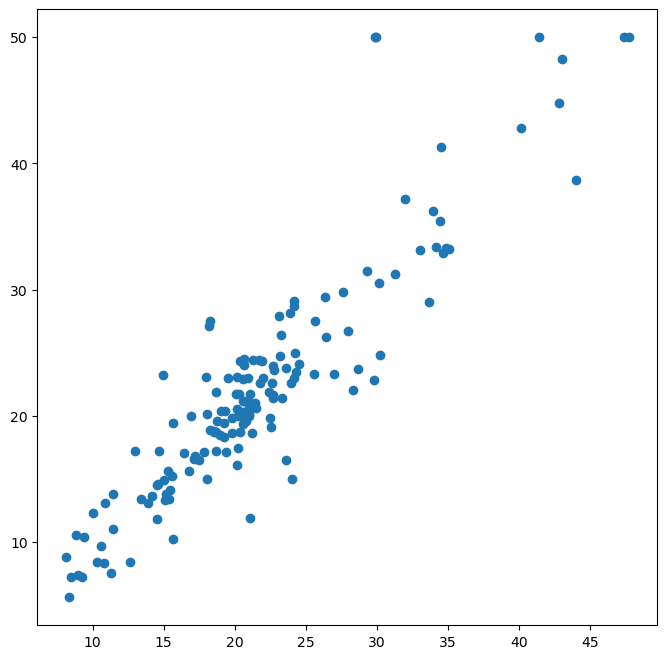

In [39]:
ax = subplots(figsize =(8 ,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag , y_test)
np.mean (( y_test - y_hat_bag)**2)

In [40]:
bag_boston = RF(max_features=X_train.shape [1],
n_estimators =500,
random_state =0).fit(X_train , y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean (( y_test - y_hat_bag)**2)

14.605662565263161

In [41]:
RF_boston = RF(max_features =6,random_state =0).fit(X_train , y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean(( y_test - y_hat_RF)**2)

20.04276446710527

In [42]:
feature_imp = pd.DataFrame({'importance':RF_boston.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

importance
lstat      0.356203
rm         0.332163
ptratio    0.067270
crim       0.055404
indus      0.053851
dis        0.041582
nox        0.035225
tax        0.025355
age        0.021506
rad        0.004784
chas       0.004203
zn         0.002454


## Overview

**Bagging:**
- A special case of random forests where all predictors (m = p) are considered for each split
- Uses RandomForestRegressor with max_features equal to the number of predictors

**Random Forests:**
- Differ from bagging by using a subset of predictors (m < p) for each split, reducing correlation between trees and improving generalization
- The default for regression in RandomForestRegressor is m = p (bagging), but here, m = 6 is used

## Results

- **Bagging** achieves a test MSE of 14.63 (or 14.61 with 500 trees), about half the MSE of the pruned single tree (28.07)
- **Random forests** (with max_features=6) yield a test MSE of 20.04, worse than bagging but still better than the single tree
- **Feature importance** analysis highlights `lstat` (percentage of lower socioeconomic status) and `rm` (average number of rooms) as the most important predictors

## Code and Explanation

### Bagging with Default Number of Trees

```python
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)
```

**Output:** `RandomForestRegressor(max_features=12, random_state=0)`

#### What it does:

**RF:**
- RF is RandomForestRegressor from sklearn.ensemble, imported earlier as RandomForestRegressor

**`bag_boston = RF(max_features=X_train.shape[1], random_state=0)`:**
- Initializes a random forest regressor for bagging:
  - `max_features=X_train.shape[1]`: Sets the number of features considered for each split to the total number of predictors (12, since X_train has 12 columns after excluding medv)
  - `random_state=0`: Ensures reproducibility
  - Default `n_estimators=100`: Uses 100 trees (not specified explicitly)
- This configures bagging, where each tree considers all 12 predictors for splits, but trees are grown on bootstrap samples of the training data

**`bag_boston.fit(X_train, y_train)`:**
- Fits the bagging model on the training set (X_train: 354 observations, y_train: corresponding medv values)
- Each of the 100 trees is trained on a bootstrap sample (random sample with replacement) of the 354 training observations

#### Why:

- **Bagging**: Bootstrap aggregating (bagging) reduces variance by averaging predictions from multiple trees, each trained on a different bootstrap sample. This improves over a single tree, which may overfit or be sensitive to data quirks
- **Why max_features=12?**: Setting max_features to the number of predictors (X_train.shape[1] = 12) means all predictors are considered for each split, making this bagging (a special case of random forests)
- **Why 100 trees?**: The default n_estimators=100 is often sufficient for bagging, balancing performance and computation

### Evaluating Bagging Performance

```python
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)
```

**Output:** `14.63`

#### What it does:

**`ax = subplots(figsize=(8,8))[1]`:**
- Creates an 8x8-inch plot for visualization

**`y_hat_bag = bag_boston.predict(X_test)`:**
- Generates predictions for the test set (X_test, 152 observations) using the bagging model
- Predictions are the average of the 100 trees' predictions for each test observation

**`ax.scatter(y_hat_bag, y_test)`:**
- Creates a scatter plot of predicted medv (y_hat_bag) vs. actual medv (y_test), visually assessing prediction accuracy (points near the 45-degree line indicate good predictions)

**`np.mean((y_test - y_hat_bag)**2)`:**
- Computes the test MSE:

```
MSE = (1/n) × Σ(yi - ŷi)²
```

- Output: 14.63, meaning predictions are, on average, √14.63 ≈ 3.83 ($3,830) from the true medv

#### Why:

- The test MSE (14.63) evaluates the bagging model's generalization performance, showing a significant improvement over the single pruned tree's MSE (28.07, or ~$5,300 error)
- The scatter plot visualizes prediction quality, helping identify patterns (e.g., under/overprediction at certain medv values)
- Bagging's lower MSE reflects the power of averaging multiple trees to reduce variance and improve predictions

### Bagging with More Trees

```python
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)
```

**Output:** `14.61`

#### What it does:

- Repeats bagging with `n_estimators=500` (500 trees) instead of the default 100
- Fits the model and computes the test MSE (14.61)

#### Why:

- Increasing `n_estimators` tests whether more trees improve performance by further reducing variance
- The MSE (14.61) is nearly identical to 14.63, suggesting 100 trees were sufficient
- **Why no overfitting?**: Bagging and random forests don't overfit with more trees, as averaging reduces variance without increasing bias. However, too few trees can lead to underfitting

### Random Forest with Fewer Features

```python
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)
```

**Output:** `20.04`

#### What it does:

**`RF_boston = RF(max_features=6, random_state=0)`:**
- Initializes a random forest with `max_features=6`, meaning each split considers a random subset of 6 predictors (out of 12)
- Default `n_estimators=100` is used
- Fits the model and computes the test MSE (20.04)

#### Why:

- **Random Forests**: Unlike bagging, random forests decorrelate trees by limiting the number of predictors considered for each split, reducing overfitting and improving generalization in some cases
- **Why max_features=6?**: Choosing m = 6 (half the predictors) balances randomness and predictive power. The default for regression in RandomForestRegressor is m = p, but here, a smaller m is tested
- **Why worse MSE?**: The random forest's MSE (20.04, ~$4,480 error) is higher than bagging's (14.61) but better than the single tree's (28.07). This suggests that restricting to 6 features may discard some predictive power in this case

### Feature Importance

```python
feature_imp = pd.DataFrame(
    {'importance': RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)
```

**Output:**
```
            importance
lstat       0.368683
rm          0.333842
ptratio     0.057306
indus       0.053303
crim        0.052426
dis         0.042493
nox         0.034410
age         0.024327
tax         0.022368
rad         0.005048
zn          0.003238
chas        0.002557
```

#### What it does:

**`RF_boston.feature_importances_`:**
- Returns an array of importance scores for each predictor, based on the total reduction in node impurity (MSE for regression) from splits on that feature, averaged across all trees

**`pd.DataFrame(...)`:**
- Creates a DataFrame with feature names as the index and importance scores

**`sort_values(by='importance', ascending=False)`:**
- Sorts features by importance, showing `lstat` (0.369) and `rm` (0.334) as the most important

#### Why:

- Feature importance quantifies each predictor's contribution to reducing MSE
- **Why lstat and rm?**: These predictors (socioeconomic status and house size) strongly influence house prices, as seen in the single tree. Their high importance reflects frequent use in splits across trees
- **Why relative measure?**: Importance is normalized to sum to 1, reflecting the relative contribution to impurity reduction

## 8.3.4 Boosting

In [43]:
boost_boston = GBR(n_estimators =5000 , learning_rate =0.001 , max_depth =3,random_state =0)
boost_boston.fit(X_train , y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

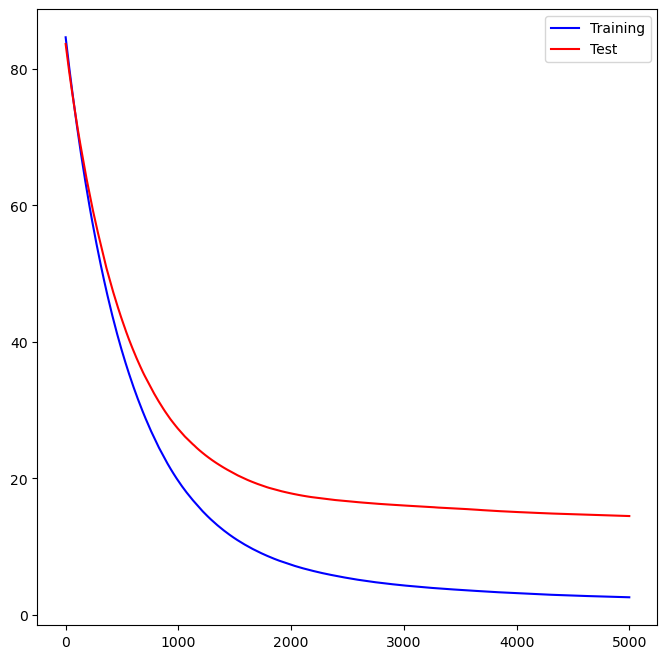

In [44]:
test_error = np.zeros_like(boost_boston.train_score_)

for idx , y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean (( y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape [0])
ax = subplots(figsize =(8 ,8))[1]

ax.plot(plot_idx , boost_boston.train_score_ , 'b', label='Training')
ax.plot(plot_idx , test_error , 'r',label='Test')
ax.legend ()

In [45]:
y_hat_boost = boost_boston.predict(X_test)
np.mean (( y_test - y_hat_boost)**2)

14.481405918831591

In [46]:
boost_boston = GBR(n_estimators =5000 , learning_rate =0.2, max_depth =3, random_state =0)
boost_boston.fit(X_train , y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean(( y_test - y_hat_boost)**2)

14.501514553719565

## Gradient Boosting

## Overview

**Gradient Boosting** uses `GradientBoostingRegressor` for regression (or `GradientBoostingClassifier` for classification).

Boosting builds trees sequentially, where each tree corrects the residuals (errors) of the previous trees, weighted by a learning rate ($\lambda$).

**Parameters**: 
- `n_estimators=5000` (number of trees)
- `max_depth=3` (tree depth)
- `learning_rate` ($\lambda$, controlling step size)

## Performance

The boosted model with $\lambda = 0.001$ achieves a test MSE of **14.48**, similar to bagging's 14.61 and better than random forests' 20.04 or the single tree's 28.07.

Increasing $\lambda$ to 0.2 yields a test MSE of **14.50**, nearly identical, suggesting robustness to the learning rate in this case.

## Error Trends

- The `train_score_` attribute tracks training error reduction over trees
- The `staged_predict` method tracks test error reduction, visualized to compare training and test performance

## Code and Explanation

### Fitting Gradient Boosting with Default Learning Rate

```python
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)
```

**What it does:**

- **GBR**: `GBR` is `GradientBoostingRegressor` from `sklearn.ensemble`, imported earlier as `GradientBoostingRegressor`
- **boost_boston = GBR(...)**: Initializes a gradient boosting regressor with:
  - `n_estimators=5000`: Builds 5,000 trees, allowing many iterations to fit residuals
  - `learning_rate=0.001`: Sets the shrinkage parameter ($\lambda$), controlling how much each tree contributes to the final prediction (small $\lambda$ means slower learning)
  - `max_depth=3`: Limits each tree to 3 levels of splits, ensuring shallow trees to prevent overfitting
  - `random_state=0`: Ensures reproducibility
- **boost_boston.fit(X_train, y_train)**: Fits the model on the training set (X_train: 354 observations, y_train: medv values)

Each tree is trained on the residuals of the previous trees, with predictions updated as:

$$F_m(x) = F_{m-1}(x) + \lambda \cdot h_m(x)$$

where $h_m(x)$ is the $m$th tree's prediction, and $\lambda = 0.001$.

**Why:**

- **Boosting**: Unlike bagging or random forests, which build independent trees, boosting builds trees sequentially to minimize errors (MSE for regression). The small learning rate ($\lambda = 0.001$) ensures gradual improvements, reducing overfitting
- **Why 5,000 trees?**: A large number of trees allows the model to refine predictions, especially with a small learning rate
- **Why max_depth=3?**: Shallow trees prevent overfitting while capturing key patterns, aligning with the single tree lab

### Tracking Training and Test Error

```python
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();
```

**What it does:**

- **boost_boston.train_score_**: Returns an array of training MSE values for each boosting iteration (1 to 5,000 trees)
- **test_error = np.zeros_like(boost_boston.train_score_)**: Initializes an array to store test MSE for each iteration
- **boost_boston.staged_predict(X_test)**: Yields predictions for the test set after each boosting iteration (i.e., after 1 tree, 2 trees, etc.)
  - For each iteration `idx`, `y_` is the prediction using the first `idx+1` trees
- **test_error[idx] = np.mean((y_test - y_)**2)**: Computes the test MSE for each iteration
- **plot_idx = np.arange(boost_boston.train_score_.shape[0])**: Creates an array of indices (0 to 4,999) for plotting
- **ax.plot(...)**: Plots training MSE (`train_score_`, blue) and test MSE (`test_error`, red) against the number of trees
- Adds a legend to distinguish training and test curves

**Why:**

- Visualizing training and test MSE over iterations shows how boosting reduces errors
- Training MSE typically decreases steadily as more trees are added
- Test MSE decreases initially but may plateau or increase if overfitting occurs (though $\lambda = 0.001$ and `max_depth=3` minimize this)
- The plot helps assess whether 5,000 trees are necessary or if fewer suffice

### Evaluating Test Performance

```python
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)
```

**Output:**
```
Out[31]: 14.48
```

**What it does:**

- **y_hat_boost = boost_boston.predict(X_test)**: Generates final predictions for the test set (152 observations) using all 5,000 trees
- **np.mean((y_test - y_hat_boost)**2)**: Computes the test MSE (14.48, or $\sqrt{14.48} \approx 3.81$, ~$3,810 error)

**Why:**

- The test MSE (14.48) evaluates the boosted model's generalization performance
- It's similar to bagging's MSE (14.61) and better than random forests' (20.04) or the single tree's (28.07), showing boosting's effectiveness

### Boosting with a Different Learning Rate

```python
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)
```

**Output:**
```
Out[32]: 14.50
```

**What it does:**

- Repeats boosting with `learning_rate=0.2` (higher than 0.001)
- Fits the model and computes the test MSE (14.50)

**Why:**

- **Learning Rate ($\lambda$)**: Controls the contribution of each tree. A higher $\lambda$ (0.2) makes larger updates, potentially converging faster but risking overfitting
- The similar MSE (14.50 vs. 14.48) suggests robustness to $\lambda$ in this case, as 5,000 trees allow sufficient iterations for convergence

## 8.3.5 Bayesian Additive Regression Trees

In [47]:
bart_boston = BART(random_state =0, burnin =5, ndraw =15)
bart_boston.fit(X_train , y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [48]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean(( y_test - yhat_test)**2)

22.145009458109225

In [49]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean (0),index=D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64

## BART (Bayesian Additive Regression Trees)

## Overview

**BART** is implemented via `BART()` from `ISLP.bart`, designed for quantitative outcomes (though other implementations support categorical outcomes via logistic/probit models).

BART combines multiple trees using a Bayesian framework, with priors to regularize tree structure and prevent overfitting.

**Parameters**: 
- `burnin=5` (number of initial MCMC iterations discarded) 
- `ndraw=15` (number of posterior samples)

## Performance

BART achieves a test MSE of **20.92**, comparable to random forests (20.04) but worse than bagging (14.61) or boosting (14.48).

## Variable Inclusion

BART provides a summary of how often each variable appears in the trees, similar to feature importance in random forests and boosting.

- `rm` (average number of rooms) and `lstat` (percentage of lower socioeconomic status) have the highest inclusion counts, indicating their importance.

## Code and Explanation

### Fitting BART

```python
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)
```

**Output:**
```
Out[33]: BART(burnin=5, ndraw=15, random_state=0)
```

**What it does:**

- **BART**: `BART` is the BART estimator from `ISLP.bart`, a Bayesian implementation of additive regression trees
- **bart_boston = BART(random_state=0, burnin=5, ndraw=15)**: Initializes the BART model with:
  - `random_state=0`: Ensures reproducibility of the Markov Chain Monte Carlo (MCMC) sampling
  - `burnin=5`: Discards the first 5 MCMC iterations to allow the chain to stabilize (burn-in phase)
  - `ndraw=15`: Retains 15 posterior samples of tree ensembles to form predictions
  - BART models the response as a sum of trees, with priors on tree depth, number of trees, and leaf values to regularize the model
- **bart_boston.fit(X_train, y_train)**: Fits the model on the training set (X_train: 354 observations, y_train: medv values)
  - Uses MCMC to sample from the posterior distribution of tree ensembles, generating a set of trees whose predictions are averaged

**Why:**

- **BART**: Combines the flexibility of tree-based models with Bayesian regularization, offering robust predictions and uncertainty quantification
- **Why burnin=5 and ndraw=15?**: These are relatively small values for computational efficiency in the lab. In practice, larger values (e.g., burnin=1000, ndraw=2000) are used for better convergence and accuracy
- **Why Bayesian?**: BART uses priors to control tree complexity, reducing overfitting compared to single trees and providing a probabilistic framework

### Evaluating Test Performance

```python
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)
```

**Output:**
```
Out[34]: 20.92
```

**What it does:**

- **bart_boston.predict(X_test.astype(np.float32))**: Generates predictions for the test set (X_test, 152 observations)
  - `X_test.astype(np.float32)` converts the test data to 32-bit floats, likely required by the ISLP.bart implementation for numerical stability or compatibility
  - Predictions are the average of the posterior tree ensembles (15 samples after burn-in)
- **np.mean((y_test - yhat_test)**2)**: Computes the test MSE:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

Output: 20.92, or $\sqrt{20.92} \approx 4.57$ (~$4,570 error).

**Why:**

- The test MSE (20.92) evaluates BART's generalization performance
- It's similar to random forests' MSE (20.04) but worse than bagging (14.61) or boosting (14.48), suggesting BART performs comparably to random forests in this case

### Variable Inclusion

```python
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                         index=D.columns)
var_inclusion
```

**Output:**
```
Out[35]:
crim       25.333333
zn         27.000000
indus      21.266667
chas       20.466667
nox        25.400000
rm         32.400000
age        26.133333
dis        25.666667
rad        24.666667
tax        23.933333
ptratio    25.000000
lstat      31.866667
dtype: float64
```

**What it does:**

- **bart_boston.variable_inclusion_**: Returns an array of variable inclusion counts, indicating how often each predictor appears in splits across the sampled trees
- **The .mean(0)**: Computes the average inclusion count over the 15 posterior samples (ndraw=15)
- **pd.Series(..., index=D.columns)**: Creates a pandas Series with inclusion counts, indexed by predictor names (D.columns)

**Output:**
- `rm` (32.4) and `lstat` (31.87) have the highest inclusion counts, followed by `zn` (27.0), `age` (26.13), and others
- Higher counts indicate greater importance in the tree ensemble

**Why:**

- Variable inclusion is analogous to feature importance in random forests/boosting, measuring how often a predictor is used in splits
- **Why rm and lstat?**: These predictors (house size and socioeconomic status) strongly influence medv, consistent with single tree, random forest, and boosting results